<a href="https://colab.research.google.com/github/neenjo/ai-and-analytics-p4/blob/main/Advanced_RP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Source Citation:
Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125. DOI:
*italicized text*


Loading Data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading Data

In [ ]:
path="/content/drive/My Drive/Study/s2 2020/Research Project Personal/Research Project/Data/drugLib_raw/drugLibTrain_raw.tsv"

In [ ]:
import pandas as pd
raw_df=pd.read_csv(path,sep='\t')

In [ ]:
raw_df.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


# Feature Selection

In [ ]:
basic_df=raw_df.iloc[:,[2,3,4,8]]

In [ ]:
basic_df.head(-5)

,rating,effectiveness,sideEffects,commentsReview
0,4,Highly Effective,Mild Side Effects,"monitor blood pressure , weight and asses for ..."
1,1,Highly Effective,Severe Side Effects,"I Hate This Birth Control, I Would Not Suggest..."
2,10,Highly Effective,No Side Effects,I took 2 pills at the onset of my menstrual cr...
3,3,Marginally Effective,Mild Side Effects,I was given Prilosec prescription at a dose of...
4,2,Marginally Effective,Severe Side Effects,See above
...,...,...,...,...
3097,8,Considerably Effective,No Side Effects,"I take one pill in the morning, and one at night."
3098,10,Highly Effective,No Side Effects,My son had been having terrible problems with ...
3099,8,Considerably Effective,Moderate Side Effects,The patient was diagnosed with ADHD after desc...
3100,7,Considerably Effective,Mild Side Effects,"I started with a low dose, then increased the ..."


DIsplaying Count

In [ ]:
basic_df['effectiveness'].value_counts()

Highly Effective          1330
Considerably Effective     928
Moderately Effective       415
Ineffective                247
Marginally Effective       187
Name: effectiveness, dtype: int64

In [ ]:
basic_df['sideEffects'].value_counts()

Mild Side Effects                1019
No Side Effects                   930
Moderate Side Effects             614
Severe Side Effects               369
Extremely Severe Side Effects     175
Name: sideEffects, dtype: int64

In [ ]:
#basic_df['condition'].value_counts()

In [ ]:
basic_df['commentsReview'].value_counts()

none                                                                                                                                                                                                                                                                                                                                                                                                                                                          6
None                                                                                                                                                                                                                                                                                                                                                                                                                                                          4
The pills are administered once a day, daily, for as long as you think it's worth taking them.  The pres

In [ ]:
basic_df.shape

(3107, 4)

Dropping all rows which has see above

In [ ]:
basic_df=basic_df.drop(basic_df[basic_df['commentsReview']=="see above"].index)

In [ ]:
basic_df.shape

(3104, 4)

3 rows deleted

Need to create a Pipeline for all the following steps

Categorising review ratings as **Negative 0 and Positive 1**

In [ ]:
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 5: # Negative Rating Cut Off (Inclusive)
      y_rank.append(0)
#    elif i >= 7: # Positive Rating Cut Off (Inclusive)
#      y_rank.append(2)
    else:  # Neutral Rating Cut off 
      y_rank.append(1)
  return y_rank

basic_df["rank_bin"] = rank_bin(basic_df["rating"])
basic_df.rank_bin.value_counts() 

1    2285
0     819
Name: rank_bin, dtype: int64

In [ ]:
basic_df.head()

,rating,effectiveness,sideEffects,commentsReview,rank_bin
0,4,Highly Effective,Mild Side Effects,"monitor blood pressure , weight and asses for ...",0
1,1,Highly Effective,Severe Side Effects,"I Hate This Birth Control, I Would Not Suggest...",0
2,10,Highly Effective,No Side Effects,I took 2 pills at the onset of my menstrual cr...,1
3,3,Marginally Effective,Mild Side Effects,I was given Prilosec prescription at a dose of...,0
4,2,Marginally Effective,Severe Side Effects,See above,0


Train Test Split with Stratisfied sampling

In [ ]:
basic_df["rank_bin"].value_counts(normalize=True)

1    0.736147
0    0.263853
Name: rank_bin, dtype: float64

Resetting Index

In [ ]:
basic_df.reset_index(drop=True, inplace=True)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(basic_df, basic_df['rank_bin']):
    strat_train_set = basic_df.loc[train_index]
    strat_test_set = basic_df.loc[test_index]

In [ ]:
  strat_train_set["rank_bin"].value_counts(normalize=True)

1    0.736164
0    0.263836
Name: rank_bin, dtype: float64

In [ ]:
strat_test_set["rank_bin"].value_counts(normalize=True)

1    0.736052
0    0.263948
Name: rank_bin, dtype: float64

Thus the ratio of rank_bin is same in both train and test data

# Classification Performance

In [ ]:
def get_performance_class(model,X,y):
  y_pred = model.predict(X)
  y_pred=get_category(y_pred)
  from sklearn.metrics import confusion_matrix
  print(confusion_matrix(y, y_pred))
  from sklearn.metrics import classification_report
  print(classification_report(y, y_pred))

# Predict rating Category from counts: RNN LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer

Train review feature

In [ ]:
strat_train_set.head()

,rating,effectiveness,sideEffects,commentsReview,rank_bin
480,8,Considerably Effective,Mild Side Effects,1 mg pill taken daily for hair loss on the cro...,1
2819,2,Ineffective,Mild Side Effects,Took Imitrex for a 3 month period and still ha...,0
309,8,Considerably Effective,Mild Side Effects,once a day at night time for a period of 3 mon...,1
2293,1,Ineffective,Extremely Severe Side Effects,This drug should NOT be on the market!,0
1725,10,Highly Effective,No Side Effects,At the start of this disorder I thought I was ...,1


In [ ]:
X_train_review_df=strat_train_set[['commentsReview','rating']]

In [ ]:
X_train_review_df

,commentsReview,rating
480,1 mg pill taken daily for hair loss on the cro...,8
2819,Took Imitrex for a 3 month period and still ha...,2
309,once a day at night time for a period of 3 mon...,8
2293,This drug should NOT be on the market!,1
1725,At the start of this disorder I thought I was ...,10
...,...,...
1669,I took 1 x 25mg per day which built up to 4 x ...,1
843,I always take the pill at night with lots of w...,10
2119,I was taking 100mg ambien each night for appro...,8
3073,I had a cold for 6 days that would not go away...,9


In [ ]:
y_train_review_df=strat_train_set['rank_bin']

In [ ]:
y_train_review_df

480     1
2819    0
309     1
2293    0
1725    1
       ..
1669    0
843     1
2119    1
3073    1
2325    1
Name: rank_bin, Length: 2638, dtype: int64

Test review features

In [ ]:
X_test_review_df=strat_test_set[['commentsReview','rating']]

In [ ]:
X_test_review_df

,commentsReview,rating
111,When my cholesterol was found to be slightly e...,1
2992,The treatment details are simply a taking one ...,9
3031,Treatment has been ongoing for several months ...,9
2686,My dotor precribed this for treatment of whipl...,3
2263,"I was experiencing hot flashes, mood swings an...",10
...,...,...
986,I began taking the product to stave off the on...,7
1779,"i started at a very low dose, to be worked up ...",1
2226,After being assessed by a psychiaterist using ...,7
2793,"It reduced the tingling sensation, and numbnes...",8


In [ ]:
y_test_review_df=strat_test_set['rank_bin']

In [ ]:
y_test_review_df

111     0
2992    1
3031    1
2686    0
2263    1
       ..
986     1
1779    0
2226    1
2793    1
1726    1
Name: rank_bin, Length: 466, dtype: int64

Converting text to **lower case**

In [ ]:
X_train_review_df['commentsReview']=X_train_review_df['commentsReview'].str.lower()
X_test_review_df['commentsReview']=X_test_review_df['commentsReview'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_train_review_df.head()

,commentsReview,rating
480,1 mg pill taken daily for hair loss on the cro...,8
2819,took imitrex for a 3 month period and still ha...,2
309,once a day at night time for a period of 3 mon...,8
2293,this drug should not be on the market!,1
1725,at the start of this disorder i thought i was ...,10


Tokenizing and padding

In [ ]:
from keras.preprocessing import sequence


In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ',oov_token="<OOV>")

In [ ]:
X_train_review_df['commentsReview']=X_train_review_df['commentsReview'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test_review_df['commentsReview']=X_test_review_df['commentsReview'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tokenizer.fit_on_texts(X_train_review_df['commentsReview'].values)

In [ ]:
tokenizer.word_index

{'<OOV>': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'and': 5,
 'a': 6,
 'of': 7,
 'was': 8,
 'my': 9,
 'it': 10,
 'for': 11,
 'in': 12,
 'with': 13,
 'day': 14,
 'have': 15,
 'that': 16,
 'on': 17,
 'take': 18,
 'this': 19,
 'as': 20,
 'not': 21,
 'at': 22,
 'is': 23,
 'but': 24,
 'after': 25,
 'me': 26,
 'had': 27,
 'one': 28,
 'taking': 29,
 'mg': 30,
 'be': 31,
 'so': 32,
 'took': 33,
 'drug': 34,
 'or': 35,
 '2': 36,
 '\r\r': 37,
 'about': 38,
 'then': 39,
 'treatment': 40,
 'medication': 41,
 'side': 42,
 'effects': 43,
 'when': 44,
 'once': 45,
 'would': 46,
 'am': 47,
 'daily': 48,
 'days': 49,
 'time': 50,
 'doctor': 51,
 'every': 52,
 'very': 53,
 'pain': 54,
 'prescribed': 55,
 'no': 56,
 'if': 57,
 'years': 58,
 '1': 59,
 'before': 60,
 'been': 61,
 'pill': 62,
 'up': 63,
 'did': 64,
 'you': 65,
 'started': 66,
 '3': 67,
 'months': 68,
 'by': 69,
 'dose': 70,
 'which': 71,
 'from': 72,
 'an': 73,
 'night': 74,
 'only': 75,
 'more': 76,
 'were': 77,
 'morning': 78,
 'taken': 79,
 'we

In [ ]:
max_words=500
X_train_review_sequence = tokenizer.texts_to_sequences(X_train_review_df['commentsReview'])
X_train_review_sequence = sequence.pad_sequences(X_train_review_sequence,maxlen=max_words)

X_test_review_sequence = tokenizer.texts_to_sequences(X_test_review_df['commentsReview'])
X_test_review_sequence = sequence.pad_sequences(X_test_review_sequence,maxlen=max_words)

In [ ]:
X_train_review_sequence

array([[  0,   0,   0, ...,   1,   6, 134],
       [  0,   0,   0, ...,  14,  11,   1],
       [  0,   0,   0, ...,   3, 159, 324],
       ...,
       [  0,   0,   0, ...,   8,  53, 141],
       [  0,   0,   0, ...,   6, 279,   1],
       [  0,   0,   0, ...,   1,  13, 106]], dtype=int32)

In [ ]:
X_train_review_sequence.shape

(2638, 500)

In [ ]:
X_test_review_sequence.shape

(466, 500)

Visualising Length of sentences

In [ ]:
len=X_train_review_df['commentsReview'].apply(lambda row: len(row))

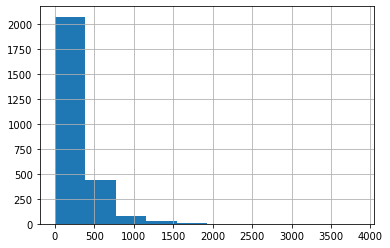

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(len).hist()
plt.show()


In [ ]:
len.describe()

count    2638.000000
mean      268.235406
std       273.660445
min         1.000000
25%        94.000000
50%       195.000000
75%       348.000000
max      3857.000000
Name: commentsReview, dtype: float64

Most of the reviews are less than **500 words**

In [ ]:
y_train_review_sequence=y_train_review_df
y_test_review_sequence=y_test_review_df

In [ ]:
y_test_review_sequence

111     0
2992    1
3031    1
2686    0
2263    1
       ..
986     1
1779    0
2226    1
2793    1
1726    1
Name: rank_bin, Length: 466, dtype: int64

In [ ]:
X_train_review_df.shape

(2638, 2)

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
embedding_size=32
vocabulary_size=5000
max_words=500
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(32,activation='relu'))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
lstm (LSTM)                  (None, 500, 256)          295936    
_________________________________________________________________
dense (Dense)                (None, 500, 32)           8224      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 546,721
Trainable params: 546,721
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [ ]:
batch_size = 32
num_epochs = 3
model.fit(X_train_review_sequence, y_train_review_sequence, validation_data=(X_test_review_sequence, y_test_review_sequence), batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
83/83 [==============================] - 390s 5s/step - loss: 0.6039 - accuracy: 0.7298 - val_loss: 0.5859 - val_accuracy: 0.7361
Epoch 2/3
83/83 [==============================] - 382s 5s/step - loss: 0.5712 - accuracy: 0.7372 - val_loss: 0.5453 - val_accuracy: 0.7361
Epoch 3/3
83/83 [==============================] - 379s 5s/step - loss: 0.5175 - accuracy: 0.7549 - val_loss: 0.5409 - val_accuracy: 0.7318


In [ ]:
res=model.predict(X_train_review_sequence)

In [ ]:

res[50:79]

array([[0.93680555],
       [0.273837  ],
       [0.94082224],
       [0.7682358 ],
       [0.8105223 ],
       [0.16833046],
       [0.686385  ],
       [0.15843657],
       [0.9191784 ],
       [0.5724978 ],
       [0.7711943 ],
       [0.84031284],
       [0.9021317 ],
       [0.86533624],
       [0.7498339 ],
       [0.78659236],
       [0.36557072],
       [0.9063928 ],
       [0.41679868],
       [0.6122178 ],
       [0.8584959 ],
       [0.45398358],
       [0.906199  ],
       [0.7667433 ],
       [0.48979467],
       [0.91093844],
       [0.7967025 ],
       [0.9427726 ],
       [0.92480904]], dtype=float32)

In [ ]:
def get_category(res):
  val=[]
  for i in res:
    if(i<0.68):
      val.append(0)
    else:
      val.append(1)
  return val

In [ ]:
val

NameError: ignored

In [ ]:
get_performance_class(model,X_train_review_sequence,y_train_review_sequence)

[[ 429  267]
 [ 380 1562]]
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       696
           1       0.85      0.80      0.83      1942

    accuracy                           0.75      2638
   macro avg       0.69      0.71      0.70      2638
weighted avg       0.77      0.75      0.76      2638



In [ ]:
get_performance_class(model,X_test_review_sequence,y_test_review_sequence)

[[ 66  57]
 [ 73 270]]
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       123
           1       0.83      0.79      0.81       343

    accuracy                           0.72       466
   macro avg       0.65      0.66      0.65       466
weighted avg       0.73      0.72      0.73       466



# Regression: Predict rating from counts: RNN LSTM

In [ ]:
from keras.preprocessing.text import Tokenizer

Train review feature

In [ ]:
strat_train_set.head()

,rating,effectiveness,sideEffects,commentsReview,rank_bin
480,8,Considerably Effective,Mild Side Effects,1 mg pill taken daily for hair loss on the cro...,1
2819,2,Ineffective,Mild Side Effects,Took Imitrex for a 3 month period and still ha...,0
309,8,Considerably Effective,Mild Side Effects,once a day at night time for a period of 3 mon...,1
2293,1,Ineffective,Extremely Severe Side Effects,This drug should NOT be on the market!,0
1725,10,Highly Effective,No Side Effects,At the start of this disorder I thought I was ...,1


In [ ]:
X_train_review_df=strat_train_set[['commentsReview','rating']]

In [ ]:
X_train_review_df

,commentsReview,rating
480,1 mg pill taken daily for hair loss on the cro...,8
2819,Took Imitrex for a 3 month period and still ha...,2
309,once a day at night time for a period of 3 mon...,8
2293,This drug should NOT be on the market!,1
1725,At the start of this disorder I thought I was ...,10
...,...,...
1669,I took 1 x 25mg per day which built up to 4 x ...,1
843,I always take the pill at night with lots of w...,10
2119,I was taking 100mg ambien each night for appro...,8
3073,I had a cold for 6 days that would not go away...,9


In [ ]:
y_train_review_df=strat_train_set['rating']

In [ ]:
y_train_review_df

480      8
2819     2
309      8
2293     1
1725    10
        ..
1669     1
843     10
2119     8
3073     9
2325    10
Name: rating, Length: 2638, dtype: int64

Test review features

In [ ]:
X_test_review_df=strat_test_set[['commentsReview','rating']]

In [ ]:
X_test_review_df

,commentsReview,rating
111,When my cholesterol was found to be slightly e...,1
2992,The treatment details are simply a taking one ...,9
3031,Treatment has been ongoing for several months ...,9
2686,My dotor precribed this for treatment of whipl...,3
2263,"I was experiencing hot flashes, mood swings an...",10
...,...,...
986,I began taking the product to stave off the on...,7
1779,"i started at a very low dose, to be worked up ...",1
2226,After being assessed by a psychiaterist using ...,7
2793,"It reduced the tingling sensation, and numbnes...",8


In [ ]:
y_test_review_df=strat_test_set['rating']

In [ ]:
y_test_review_df

111      1
2992     9
3031     9
2686     3
2263    10
        ..
986      7
1779     1
2226     7
2793     8
1726    10
Name: rating, Length: 466, dtype: int64

Converting text to **lower case**

In [ ]:
X_train_review_df['commentsReview']=X_train_review_df['commentsReview'].str.lower()
X_test_review_df['commentsReview']=X_test_review_df['commentsReview'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
X_train_review_df.head()

,commentsReview,rating
480,1 mg pill taken daily for hair loss on the cro...,8
2819,took imitrex for a 3 month period and still ha...,2
309,once a day at night time for a period of 3 mon...,8
2293,this drug should not be on the market!,1
1725,at the start of this disorder i thought i was ...,10


Tokenizing and padding

In [ ]:
from keras.preprocessing import sequence


In [ ]:
tokenizer = Tokenizer(num_words=500, split=' ',oov_token="<OOV>")

In [ ]:
X_train_review_df['commentsReview']=X_train_review_df['commentsReview'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_test_review_df['commentsReview']=X_test_review_df['commentsReview'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
tokenizer.fit_on_texts(X_train_review_df['commentsReview'].values)

In [ ]:
tokenizer.word_index

{'<OOV>': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'and': 5,
 'a': 6,
 'of': 7,
 'was': 8,
 'my': 9,
 'it': 10,
 'for': 11,
 'in': 12,
 'with': 13,
 'day': 14,
 'have': 15,
 'that': 16,
 'on': 17,
 'take': 18,
 'this': 19,
 'as': 20,
 'not': 21,
 'at': 22,
 'is': 23,
 'but': 24,
 'after': 25,
 'me': 26,
 'had': 27,
 'one': 28,
 'taking': 29,
 'mg': 30,
 'be': 31,
 'so': 32,
 'took': 33,
 'drug': 34,
 'or': 35,
 '2': 36,
 '\r\r': 37,
 'about': 38,
 'then': 39,
 'treatment': 40,
 'medication': 41,
 'side': 42,
 'effects': 43,
 'when': 44,
 'once': 45,
 'would': 46,
 'am': 47,
 'daily': 48,
 'days': 49,
 'time': 50,
 'doctor': 51,
 'every': 52,
 'very': 53,
 'pain': 54,
 'prescribed': 55,
 'no': 56,
 'if': 57,
 'years': 58,
 '1': 59,
 'before': 60,
 'been': 61,
 'pill': 62,
 'up': 63,
 'did': 64,
 'you': 65,
 'started': 66,
 '3': 67,
 'months': 68,
 'by': 69,
 'dose': 70,
 'which': 71,
 'from': 72,
 'an': 73,
 'night': 74,
 'only': 75,
 'more': 76,
 'were': 77,
 'morning': 78,
 'taken': 79,
 'we

In [ ]:
max_words=500
X_train_review_sequence = tokenizer.texts_to_sequences(X_train_review_df['commentsReview'])
X_train_review_sequence = sequence.pad_sequences(X_train_review_sequence,maxlen=max_words)

X_test_review_sequence = tokenizer.texts_to_sequences(X_test_review_df['commentsReview'])
X_test_review_sequence = sequence.pad_sequences(X_test_review_sequence,maxlen=max_words)

In [ ]:
X_train_review_sequence

array([[  0,   0,   0, ...,   1,   6, 134],
       [  0,   0,   0, ...,  14,  11,   1],
       [  0,   0,   0, ...,   3, 159, 324],
       ...,
       [  0,   0,   0, ...,   8,  53, 141],
       [  0,   0,   0, ...,   6, 279,   1],
       [  0,   0,   0, ...,   1,  13, 106]], dtype=int32)

In [ ]:
X_train_review_sequence.shape

(2638, 500)

In [ ]:
X_test_review_sequence.shape

(466, 500)

Visualising Length of sentences

In [ ]:
len_train=X_train_review_df['commentsReview'].apply(lambda row: len(row))

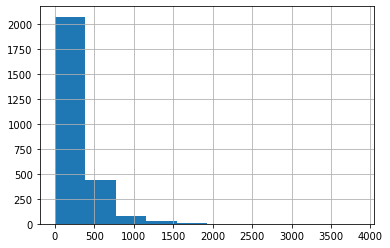

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
pd.Series(len_train).hist()
plt.show()


In [ ]:
len_train.describe()

count    2638.000000
mean      268.235406
std       273.660445
min         1.000000
25%        94.000000
50%       195.000000
75%       348.000000
max      3857.000000
Name: commentsReview, dtype: float64

Most of the reviews are less than **500 words**

In [ ]:
y_train_review_sequence=y_train_review_df
y_test_review_sequence=y_test_review_df

In [ ]:
y_test_review_sequence

111      1
2992     9
3031     9
2686     3
2263    10
        ..
986      7
1779     1
2226     7
2793     8
1726    10
Name: rating, Length: 466, dtype: int64

In [ ]:
X_train_review_df.shape

(2638, 2)

In [ ]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
embedding_size=32
vocabulary_size=5000
max_words=500
model=Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(196, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 500, 1024)         4329472   
_________________________________________________________________
dense_6 (Dense)              (None, 500, 512)          524800    
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 5,801,985
Trainable params: 5,801,985
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [ ]:
batch_size = 64
num_epochs = 10
model.fit(X_train_review_sequence, y_train_review_sequence, validation_data=(X_test_review_sequence, y_test_review_sequence), batch_size=batch_size, epochs=num_epochs)

Epoch 1/10


In [ ]:
res=model.predict(X_train_review_sequence)

In [ ]:

res[50:79]

array([[0.93680555],
       [0.273837  ],
       [0.94082224],
       [0.7682358 ],
       [0.8105223 ],
       [0.16833046],
       [0.686385  ],
       [0.15843657],
       [0.9191784 ],
       [0.5724978 ],
       [0.7711943 ],
       [0.84031284],
       [0.9021317 ],
       [0.86533624],
       [0.7498339 ],
       [0.78659236],
       [0.36557072],
       [0.9063928 ],
       [0.41679868],
       [0.6122178 ],
       [0.8584959 ],
       [0.45398358],
       [0.906199  ],
       [0.7667433 ],
       [0.48979467],
       [0.91093844],
       [0.7967025 ],
       [0.9427726 ],
       [0.92480904]], dtype=float32)

In [ ]:
def get_category(res):
  val=[]
  for i in res:
    if(i<0.68):
      val.append(0)
    else:
      val.append(1)
  return val

In [ ]:
val

NameError: ignored

In [ ]:
get_performance_class(model,X_train_review_sequence,y_train_review_sequence)

[[ 429  267]
 [ 380 1562]]
              precision    recall  f1-score   support

           0       0.53      0.62      0.57       696
           1       0.85      0.80      0.83      1942

    accuracy                           0.75      2638
   macro avg       0.69      0.71      0.70      2638
weighted avg       0.77      0.75      0.76      2638



In [ ]:
get_performance_class(model,X_test_review_sequence,y_test_review_sequence)

[[ 66  57]
 [ 73 270]]
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       123
           1       0.83      0.79      0.81       343

    accuracy                           0.72       466
   macro avg       0.65      0.66      0.65       466
weighted avg       0.73      0.72      0.73       466



# Categorical Data Preprocessing

One hot encoding

In [ ]:
strat_train_set.head()

,rating,effectiveness,sideEffects,commentsReview,rank_bin
480,8,Considerably Effective,Mild Side Effects,1 mg pill taken daily for hair loss on the cro...,1
2819,2,Ineffective,Mild Side Effects,Took Imitrex for a 3 month period and still ha...,0
309,8,Considerably Effective,Mild Side Effects,once a day at night time for a period of 3 mon...,1
2293,1,Ineffective,Extremely Severe Side Effects,This drug should NOT be on the market!,0
1725,10,Highly Effective,No Side Effects,At the start of this disorder I thought I was ...,1


Creating X_train and y_train

In [ ]:
X_train=strat_train_set[["effectiveness","sideEffects"]]

In [ ]:
X_train.head()

,effectiveness,sideEffects
480,Considerably Effective,Mild Side Effects
2819,Ineffective,Mild Side Effects
309,Considerably Effective,Mild Side Effects
2293,Ineffective,Extremely Severe Side Effects
1725,Highly Effective,No Side Effects


In [ ]:
y_train=strat_train_set["rating"]

In [ ]:
y_train.head()

480      8
2819     2
309      8
2293     1
1725    10
Name: rating, dtype: int64

Creating X_test and y_test

In [ ]:
X_test=strat_test_set[["effectiveness","sideEffects"]]

In [ ]:
X_test.head()

,effectiveness,sideEffects
111,Ineffective,Severe Side Effects
2992,Considerably Effective,No Side Effects
3031,Considerably Effective,No Side Effects
2686,Ineffective,Moderate Side Effects
2263,Highly Effective,Mild Side Effects


In [ ]:
y_test=strat_test_set["rating"]

In [ ]:
y_test.head()

111      1
2992     9
3031     9
2686     3
2263    10
Name: rating, dtype: int64

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [ ]:
ct=ColumnTransformer(transformers=[('encoder',OneHotEncoder(sparse=False,drop='first'),[0,1])])

In [ ]:
X_train=ct.fit_transform(X_train)
X_test=ct.transform(X_test)

In [ ]:
X_train=pd.DataFrame(data=X_train,columns=ct.get_feature_names())
X_test=pd.DataFrame(data=X_test,columns=ct.get_feature_names())

In [ ]:
X_train.head()

,encoder__x0_Highly Effective,encoder__x0_Ineffective,encoder__x0_Marginally Effective,encoder__x0_Moderately Effective,encoder__x1_Mild Side Effects,encoder__x1_Moderate Side Effects,encoder__x1_No Side Effects,encoder__x1_Severe Side Effects
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Categorical Model: Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [600],
    'max_features': [5,6,7,8],
#    'max_features':['auto', 'sqrt'],

    'min_samples_leaf': [2,4,8,10,15],
    'min_samples_split': [10,20,40,50],
    'n_estimators': [25,50,100,200,300]
}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 3)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   27.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  5.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [ ]:
model=grid_search.best_estimator_

In [ ]:
model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=600, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=25, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Performance

In [ ]:
def get_performance_R(model,X,y):
  y_pred = model.predict(X)
  from sklearn.metrics import r2_score
  print(r2_score(y, y_pred))

get_performance_R(model,X_train,y_train)


0.7846241550377178


In [ ]:
get_performance_R(model,X_test,y_test)


0.8059652800789897


In [ ]:
X_train.columns.to_list()

['encoder__x0_Highly Effective',
 'encoder__x0_Ineffective',
 'encoder__x0_Marginally Effective',
 'encoder__x0_Moderately Effective',
 'encoder__x1_Mild Side Effects',
 'encoder__x1_Moderate Side Effects',
 'encoder__x1_No Side Effects',
 'encoder__x1_Severe Side Effects']

In [ ]:
for name, score in zip(X_train.columns.to_list(), model.feature_importances_):
  print(name, score)

encoder__x0_Highly Effective 0.22013692018290795
encoder__x0_Ineffective 0.33291039512074355
encoder__x0_Marginally Effective 0.0847554350876031
encoder__x0_Moderately Effective 0.03955506563407701
encoder__x1_Mild Side Effects 0.08449597225219169
encoder__x1_Moderate Side Effects 0.057888195576809236
encoder__x1_No Side Effects 0.049793740279940386
encoder__x1_Severe Side Effects 0.13046427586572712


# Merged Prediction